In [137]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import random
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from scipy.stats import norm
from sklearn.preprocessing import Normalizer,StandardScaler, LabelEncoder
from tensorflow_addons.losses import pinball_loss
from sklearn.metrics import mean_pinball_loss
from scipy import stats
import math

In [138]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
horizons = [36, 48 ,60, 72, 84]

# Prepare data

In [139]:
data = pd.read_feather("data/berlin_data/historic_data/icon_eps_t_2m.feather")
data.dropna(inplace=True)
data.head()

,init_tm,met_var,location,fcst_hour,obs_tm,obs,ens_1,ens_2,ens_3,ens_4,...,ens_33,ens_34,ens_35,ens_36,ens_37,ens_38,ens_39,ens_40,ens_mean,ens_var
0,2018-12-13 00:00:00+00:00,t_2m,Berlin,0.0,2018-12-13 00:00:00+00:00,2.3,0.05,0.03,0.32,0.61,...,0.30,-0.03,0.44,0.42,0.05,0.47,0.51,0.74,0.34500,0.148036
1,2018-12-13 00:00:00+00:00,t_2m,Berlin,1.0,2018-12-13 01:00:00+00:00,2.3,0.06,0.00,0.34,0.51,...,0.13,0.05,0.39,0.38,0.04,0.38,0.33,0.60,0.30125,0.162580
2,2018-12-13 00:00:00+00:00,t_2m,Berlin,2.0,2018-12-13 02:00:00+00:00,2.2,0.10,0.11,0.40,0.45,...,0.08,0.15,0.57,0.37,0.08,0.42,0.31,0.57,0.32525,0.171626
3,2018-12-13 00:00:00+00:00,t_2m,Berlin,3.0,2018-12-13 03:00:00+00:00,2.2,0.12,0.32,0.48,0.42,...,0.05,0.19,0.68,0.32,0.08,0.28,0.35,0.60,0.31700,0.161878
4,2018-12-13 00:00:00+00:00,t_2m,Berlin,4.0,2018-12-13 04:00:00+00:00,2.1,0.11,0.57,0.54,0.35,...,0.03,0.17,0.76,0.30,0.10,0.11,0.34,0.56,0.29275,0.150544


## Calculate positional encoding for day of year

In [140]:
pos_enc = pd.DataFrame(index=pd.DatetimeIndex(data["obs_tm"]))
pos_enc["Dayofyear"] = pos_enc.index.dayofyear
pos_enc["n_days"] = 365
pos_enc.loc[pos_enc.index.year==2020,"n_days"] = 366
#Calculate actual positional encoding
sin_encoding = np.sin(2*math.pi*pos_enc["Dayofyear"]/pos_enc["n_days"])
cos_encoding = np.cos(2*math.pi*pos_enc["Dayofyear"]/pos_enc["n_days"])
#data["pos_enc_1"] = sin_encoding.to_numpy()
#data["pos_enc_2"] = cos_encoding.to_numpy()

## Train, val, test split

In [141]:
train_val_dataframe, test_dataframe = train_test_split(data, test_size = 0.2, random_state = 1)
train_dataframe, val_dataframe = train_test_split(data, test_size = 0.2, random_state = 2)

## Normalize and change format

In [142]:
def normalize(dataframe, label_encoder = None,feature_scaler = None, target_scaler = None, learn = False):
    #Drop unused columns
    data = dataframe.copy()
    data.drop(["init_tm", "met_var", "location", "ens_mean", "ens_var", "obs_tm"], axis = 1, inplace = True)
    data = data.to_numpy()
    if learn == True:
        label_encoder = LabelEncoder()
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler()
        #Learn label encoding for horizons
        label = label_encoder.fit_transform(data[:,0])
        #Learn target scaling
        target_scaled = target_scaler.fit_transform(data[:,1].reshape(-1,1))
        #Learn feature scaling
        features_scaled = feature_scaler.fit_transform(data[:,2:])
        #Append
        data[:,0] = label
        data[:,1] = target_scaled.reshape(-1)
        data[:,2:] = features_scaled
        
        return data, label_encoder, feature_scaler, target_scaler
    
    else:
        #Learn labels
        label = label_encoder.transform(data[:,0])
        #Scale target
        target_scaled = target_scaler.transform(data[:,1].reshape(-1,1))
        #Scale features
        features_scaled = feature_scaler.transform(data[:,2:])
        #Append
        data[:,0] = label
        data[:,1] = target_scaled.reshape(-1)
        data[:,2:] = features_scaled
        
        return data

In [143]:
train_val, label_encoder, feature_scaler, target_scaler = normalize(train_val_dataframe, learn = True)
train= normalize(train_dataframe, label_encoder, feature_scaler, target_scaler)
test = normalize(test_dataframe, label_encoder, feature_scaler, target_scaler)
val = normalize(val_dataframe, label_encoder, feature_scaler, target_scaler)
#Number of encodings
n_encodings = len(np.unique(train[:,0]))

In [144]:
def convert_format(input_data, predict = False):
    #Extract forecast embedding
    horizon_emb = input_data[:,0]
    
    if predict == False:        
        #Extract features
        features = input_data[:,2:]
        # Extract target
        target = np.expand_dims(input_data[:,1],1)
        return [features, horizon_emb], target
    else:
        #Extract features
        features = input_data[:,1:]
        return [features, horizon_emb]

In [145]:
train_data, train_target = convert_format(train)
val_data, val_target = convert_format(val)
test_data, test_target = convert_format(test)

# Build model

In [146]:
BATCH_SIZE = 1024
EPOCHS = 100
learning_rate = 0.001

In [147]:
class base_model(tf.keras.Model):    
    def __init__(self, n_embeddings = n_encodings):
        super(base_model, self).__init__()
        #Embedding layers
        self.embedding = Embedding(input_dim = n_embeddings, output_dim = 4)
        #Create Dense layers
        self.hidden = Dense(25, activation = "relu")
        self.out = Dense(1, activation = "linear")

    def call(self, input_data):
        #Extract data
        features, horizon_emb = input_data
        #Calculate embedding
        emb = self.embedding(horizon_emb)
        emb = tf.squeeze(emb, axis = 1)
        conc = Concatenate(axis = 1)([features, emb])
        #Calculate output
        output = self.hidden(conc)
        output = self.out(output)

        return output

In [148]:
def train_model(model, quantile, train_data, train_target, validation_data, batch_size, epochs, learning_rate):
    #Define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    #Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, min_delta = 1e-5)
    #Compile model
    model.compile(optimizer = optimizer, loss = lambda true,pred: pinball_loss(true, pred, tau = quantile))
    model.fit(x = train_data, y = train_target, validation_data = validation_data, epochs = epochs, batch_size = batch_size, callbacks = [callback], shuffle = True, verbose = False)

In [149]:
def create_all_models(train_data, train_target, validation_data, batch_size = BATCH_SIZE, epochs = EPOCHS, learning_rate = learning_rate, quantiles = quantiles):
    models = []
    for quantile in quantiles:
        model = base_model()
        train_model(model, quantile, train_data, train_target, validation_data, batch_size, epochs, learning_rate)
        print("Training finished for quantile: {}".format(quantile))
        models.append(model)
    return models

In [150]:
trained_models = create_all_models(train_data, train_target, (val_data, val_target))

Training finished for quantile: 0.025
Training finished for quantile: 0.25
Training finished for quantile: 0.5
Training finished for quantile: 0.75
Training finished for quantile: 0.975


# Predict test data

## Evaluate pinball loss

In [151]:
predictions = []
for cnt,_ in enumerate(quantiles):
    pred = trained_models[cnt].predict(test_data)
    predictions.append(pred)

In [152]:
for cnt,quantile in enumerate(quantiles):
    loss = mean_pinball_loss(test_target.reshape(-1), predictions[cnt].reshape(-1), alpha = quantile)
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))

Pinball loss for quantile 0.025 : 	 0.010487159253515387
Pinball loss for quantile 0.25 : 	 0.051333231353251504
Pinball loss for quantile 0.5 : 	 0.06248383631100207
Pinball loss for quantile 0.75 : 	 0.04897710079069306
Pinball loss for quantile 0.975 : 	 0.009403187319116171


## Evaluate pinball loss for naive prediction

In [153]:
naive_pred = np.quantile(test_data[0], quantiles, axis = 1)
for cnt,quantile in enumerate(quantiles):
    loss = mean_pinball_loss(np.squeeze(test_target), naive_pred[cnt], alpha = quantile)
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))

Pinball loss for quantile 0.025 : 	 0.01653744349584136
Pinball loss for quantile 0.25 : 	 0.05327983101156577
Pinball loss for quantile 0.5 : 	 0.06403634347836257
Pinball loss for quantile 0.75 : 	 0.05296768490014769
Pinball loss for quantile 0.975 : 	 0.017573657479385784


## Check plausability of model

In [154]:
for cnt,pred in enumerate(predictions):
    q_smaller = (pred > test_target).sum()
    emp_quant = q_smaller / pred.size
    print("Quantile met for quantile = {}: \t {} %".format(quantiles[cnt], np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 1.7399999999999998 %
Quantile met for quantile = 0.25: 	 28.01 %
Quantile met for quantile = 0.5: 	 54.99000000000001 %
Quantile met for quantile = 0.75: 	 79.09 %
Quantile met for quantile = 0.975: 	 97.13000000000001 %


## Visualize predictions

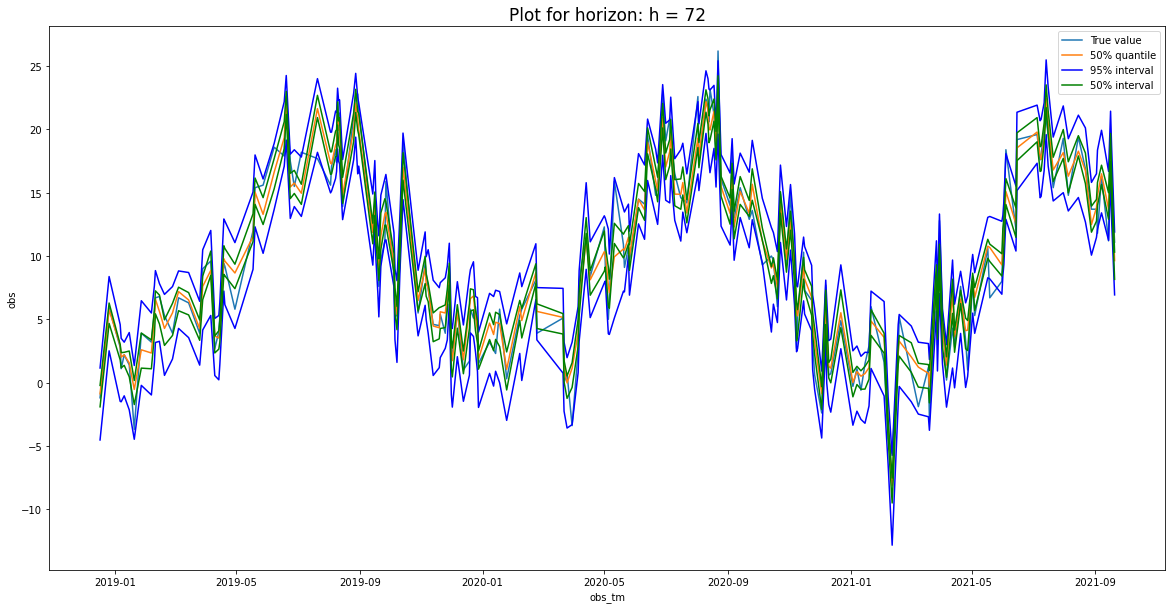

In [156]:
# Create plotting dataframe
data_plot = test_dataframe[["obs_tm","obs","fcst_hour"]].copy()
for cnt, quantile in enumerate(quantiles):
    data_plot["q{}".format(quantile)] = target_scaler.inverse_transform(predictions[cnt]).reshape(-1)

#Extract horizon
h=72
data_plot = data_plot[data_plot["fcst_hour"]==h]

fig, axs = plt.subplots(figsize = (20,10))
sns.lineplot(x = "obs_tm", y = "obs", data = data_plot, label = "True value")
sns.lineplot(x = "obs_tm", y = "q0.5", data = data_plot, label = "50% quantile")
sns.lineplot(x = "obs_tm", y = "q0.025", data = data_plot, color = "blue", label = "95% interval")
sns.lineplot(x = "obs_tm", y = "q0.975", data = data_plot, color = "blue")

sns.lineplot(x = "obs_tm", y = "q0.25", data = data_plot, color = "green", label = "50% interval")
sns.lineplot(x = "obs_tm", y = "q0.75", data = data_plot, color = "green")
axs.set_title("Plot for horizon: h = {}".format(h),size = 17)
axs.legend()

# Predict new data

## Train on complete data

In [22]:
train_data, train_target = convert_format(train_val)
val_data, val_target = convert_format(test)

In [23]:
trained_models = create_all_models(train_data, train_target, (val_data, val_target))

Training finished for quantile: 0.025
Training finished for quantile: 0.25
Training finished for quantile: 0.5
Training finished for quantile: 0.75
Training finished for quantile: 0.975


## Predict new data

In [24]:
#Set current date
current_date = (date.today()).strftime("%Y%m%d")
path = "data/berlin_data/icon_data/icon-eu-eps_{}00_t_2m_Berlin.txt".format(current_date)
new_data = pd.read_csv(path.format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data.columns = new_data.columns.str.replace(" ", "")
# Normalize and get horizons
new_data = new_data[new_data["fcst_hour"].isin(horizons)].to_numpy()
new_data[:,1:] = feature_scaler.transform(new_data[:,1:])

In [25]:
pred_data = convert_format(new_data, predict = True)

In [26]:
#Prepare dataframe
final_prediction = pd.DataFrame(columns = ["forecast_date","target","horizon","q0.025","q0.25","q0.5","q0.75","q0.975"], index = np.arange(0,5))
final_prediction["forecast_date"] = datetime.today().strftime("%Y-%m-%d")
final_prediction["horizon"] = ["{} hour".format(x) for x in horizons]
final_prediction["target"] = "temperature"

In [27]:
for cnt, quantile in enumerate(quantiles):
    #Get prediction
    prediction = trained_models[cnt].predict(pred_data)
    #Retransform
    final_pred = target_scaler.inverse_transform(prediction)
    final_prediction.loc[:,"q{}".format(quantile)] = final_pred

In [28]:
final_prediction

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2021-11-24,temperature,36 hour,0.715944,2.108084,3.170525,3.291906,6.084178
1,2021-11-24,temperature,48 hour,1.543389,3.172759,3.909042,4.293498,6.522366
2,2021-11-24,temperature,60 hour,2.961791,4.908102,5.713093,6.076737,8.300484
3,2021-11-24,temperature,72 hour,-0.238702,1.827929,2.436162,2.753498,5.474703
4,2021-11-24,temperature,84 hour,1.720604,3.900187,4.672521,5.175116,7.792253


In [29]:
new_data = pd.read_csv(path.format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data.columns = new_data.columns.str.replace(" ", "")
new_data[new_data["fcst_hour"].isin(horizons)].quantile(0.5, axis = 1)

36    2.14
48    2.84
52    4.82
56    1.17
58    3.81
Name: 0.5, dtype: float64

In [30]:
final_prediction.to_pickle("../evaluation/predictions/single/{}_{}".format("temperature", date.today().strftime("%Y-%m-%d")))

# Old code

## Check relationship with time

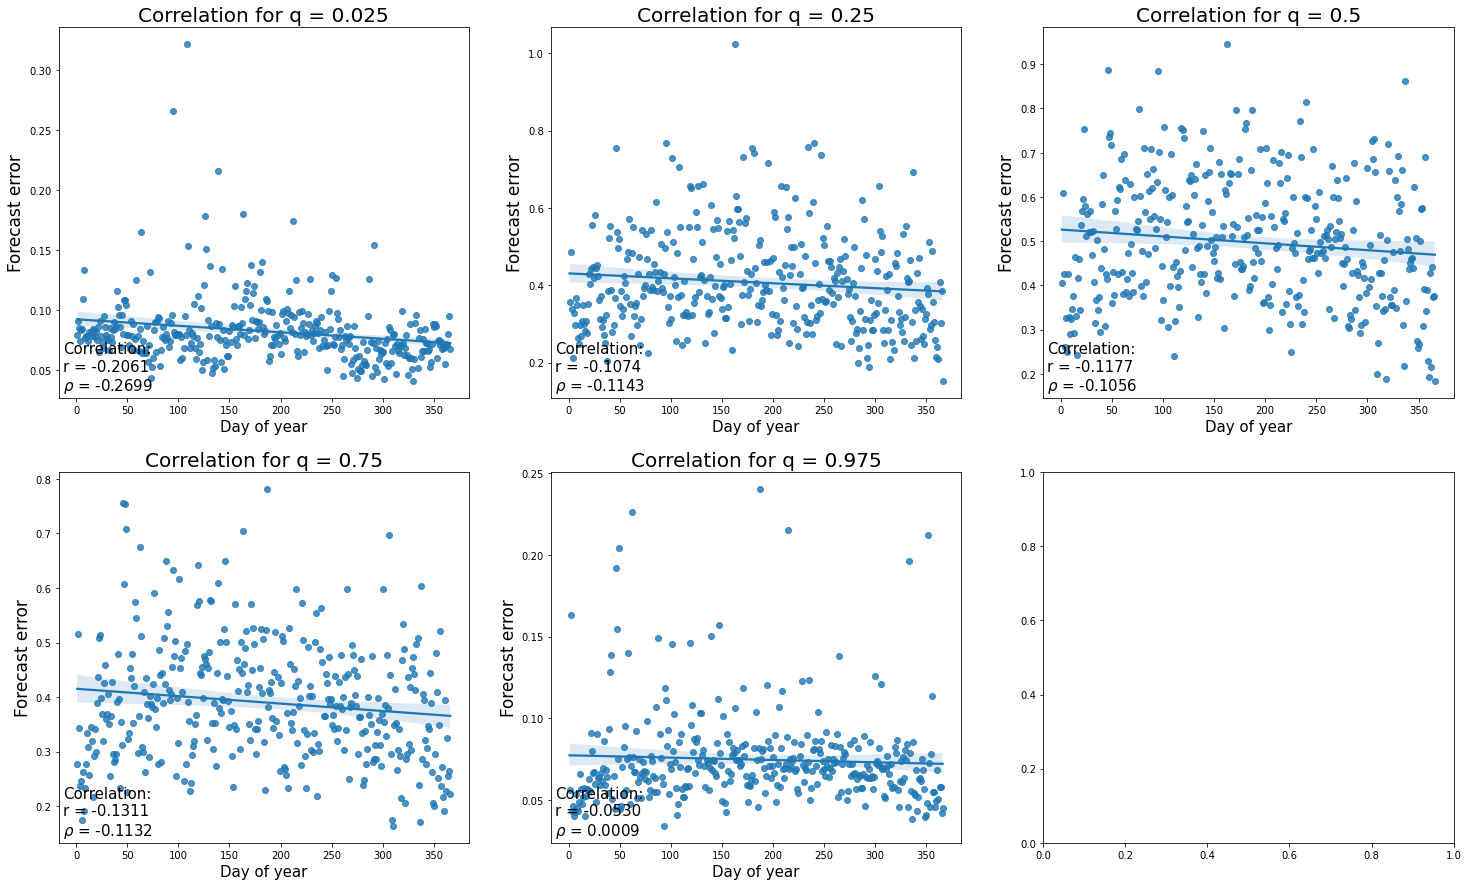

In [155]:
fig, ax = plt.subplots(2,3,figsize=(25,15))
ax = ax.ravel()
for cnt, quantile in enumerate(quantiles):
    #Renormalize and calculate forecast error
    error = mean_pinball_loss(test_dataframe["obs"].to_numpy().reshape(1,-1), target_scaler.inverse_transform(predictions[cnt]).reshape(1,-1), multioutput="raw_values", alpha=quantile)
    test_dataframe["Forecast_error"] = error
    test_dataframe["day"] = pd.DatetimeIndex(test_dataframe["obs_tm"]).dayofyear
    plot = test_dataframe.groupby("day").mean().reset_index()

    sns.regplot(x = "day", y = "Forecast_error", data=plot, ax = ax[cnt])
    ax[cnt].set_xlabel("Day of year",size = 15)
    ax[cnt].set_ylabel("Forecast error", size = 17)
    ax[cnt].set_title("Correlation for q = {}".format(quantile),size = 20)
    r = stats.pearsonr(plot["day"], plot["Forecast_error"])[0]
    rho = stats.spearmanr(plot["day"], plot["Forecast_error"])[0]
    ax[cnt].annotate('Correlation:\nr = {:.4f}\n'.format(r)+r'$\rho$ = {:.4f}'.format(rho),xy = (.01,.02), xycoords=ax[cnt].transAxes, size = 15)
    
plt.savefig("temp_time_correlation_plot.pdf", dpi=300)